# Ejercicio 2

Importamos las librerías que vamos a usar junto con la función para cargar los datos:

In [1]:
import numpy as np
import networkx as nx
from scipy.optimize import curve_fit
from itertools import chain
from matplotlib import pyplot as plt
%matplotlib notebook

def ldata(archive):
    f = open(archive)
    data = []
    for line in f:
        line = line.strip()
        col = line.split()
        data.append(col)	
    return data

Cargamos los datos y creamos un grafo a partir de las relaciones entre un grupo de delfines. Le asignamos a cada uno su género (atributo 'gender'):

In [9]:
dolphins = nx.read_gml('TC01_data/dolphins.gml')
gender = ldata('TC01_data/dolphinsGender.txt')
gender = [gender[n][1] for n in range(len(gender))]

for n,g in zip(dolphins.nodes,gender):
    dolphins.nodes[n]["gender"] = g
    
dolphins_original = dolphins

### Layout de la red
Entre los layouts propuestos (random, circular, spectral, shell, spring), el formato 'spring' permitió observar dos grupos.

<IPython.core.display.Javascript object>


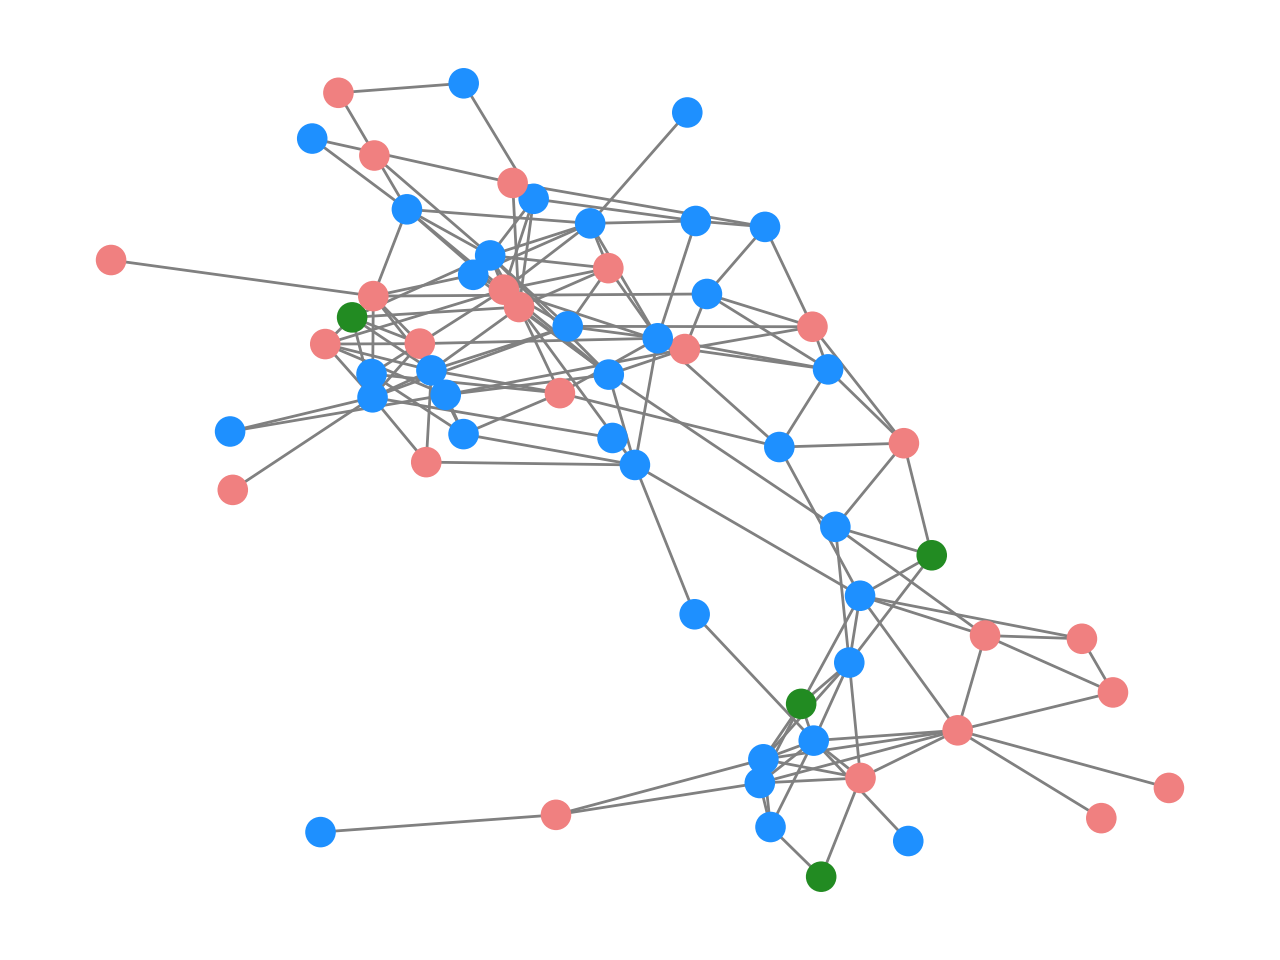

In [3]:
colores = []
for g in nx.get_node_attributes(dolphins, "gender").values():  
    if g == 'm': 
        colores.append('dodgerblue')
    elif g == 'NA':
        colores.append('forestgreen')
    else:
        colores.append('lightcoral')
                       
nx.draw(dolphins,
        node_color = colores, 
        node_size = 100, edge_color = 'grey')

### Cuantificación de la homofilia

Nos interesa saber si se trata de una red donde prevalece la homofilia en la variable género. Para ello, consideramos la dstribución nula para la fracción de enlaces que vinculan géneros diferentes. Dicha distribución se generó a partir de $n=10000$ asignaciones aleatorias de género, preservando la topología de la red (nodos y enlaces) y la proporción de cada género. 

Empezamos definiendo dos funciones que nos permitirán generar los modelos nulos y extraer información de ellos:

In [4]:
def straight(graph):
    
    ## Devuelve el número de enlaces inter-género (heterosexuales) de la red
    
    edges = list(dict(graph.edges))
    hetero = [ edges[n] if graph.nodes[edges[n][0]] != graph.nodes[edges[n][1]] 
    else '' for n in range(graph.number_of_edges())]
    hetero = list(set(list(hetero)))[1:]
    return len(hetero)
    
    
def bend(graph, attribute, name_attribute='gender'):
       
    ## Reasigna un atributo aleatoriamente manteniendo la proporción original del mismo
    
    np.random.shuffle(attribute)
    for n,g in zip(graph.nodes,attribute):
        graph.nodes[n][name_attribute] = g               
    return graph 

A continuación generamos los modelos nulos usando la función 'bend' y luego medimos la fracción de enlaces inter-género con 'straight'. Este procedimiento se realizó 10000 veces. Se realizó un histograma con los datos obtenidos para plasmar la distribución nula.

<IPython.core.display.Javascript object>


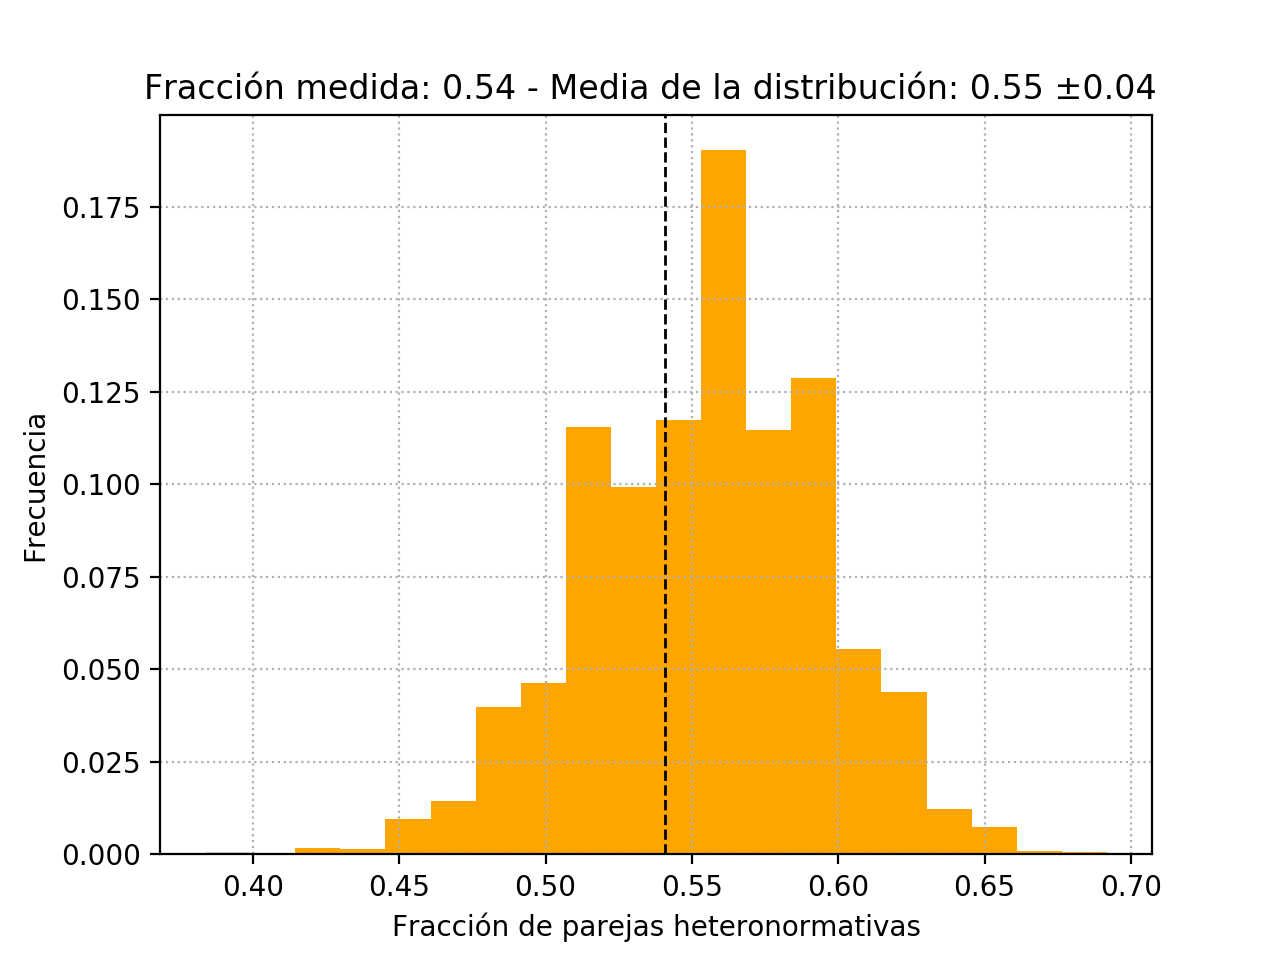

Fracción de parejas heterosexuales en red original: 0.54
Media y desviación de la ditribución nula: 0.55 ± 0.04


In [5]:
times = 10000
fraccion = []
## Fracción de parejas inter-género
fraccion_medida = straight(dolphins)/dolphins.number_of_edges() 

for n in range(times):
    dolphins = bend(dolphins, gender, name_attribute='gender')
    fraccion.append(straight(dolphins)/dolphins.number_of_edges())
    
freq, binedges = np.histogram(fraccion, bins=20)
norm = sum(freq)
freq_normed = [i/norm for i in freq]
bincenters = 0.5*(binedges[1:]+binedges[:-1])
lins = {'linestyle': 'None'}

mean = np.mean(fraccion)
stdev = np.std(fraccion)

plt.rc('lines', **lins)
plt.axvline(x=fraccion_medida, color='k', linestyle='dashed', linewidth=1)
plt.bar(bincenters,freq_normed, color='orange',edgecolor='black', linewidth=1.2, width = np.diff(binedges))
plt.grid(linestyle=':')
plt.ylabel('Frecuencia')
plt.xlabel('Fracción de parejas heteronormativas' )
plt.title('Fracción medida: %s - Media de la distribución: %s ±% s ' 
%(round(fraccion_medida,2),round(mean,2 ),round(stdev,2) ))
plt.show()

print('Fracción de parejas heterosexuales en red original: %s' %round(fraccion_medida,2))
print('Media y desviación de la ditribución nula: %s ± % s' %(round(mean,2), round(stdev,2)))

La hipótesis nula propuesta no nos permite extraer información reelevante, pues la fracción de parejas inter-género pertenece al intervalo de la media y desviación de nuestra distribución.

De todas maneras, para cuantificar si el valor de enlaces heterosexuales original era esperado según la hipótesis propuesta, se calculó el p-value.

In [6]:
def pval(freq,bines,Tobs):
    bineslef = bines[:-1]
    cumprob = [sum(freq[0:i+1]) for i in range(len(freq))]
    i = 1
    if bineslef[0] >= Tobs:
        return 1
    elif bineslef[-1] < Tobs:
        return 1 - cumprob[-1]
    else:
        while bineslef[i] < Tobs:
            if i < len(bineslef)-1:
                i+=1
            else:
                break
        return 1 - cumprob[i-1] 
    
p_val = pval(freq_normed, binedges, fraccion_medida)

print('p-value del estadístico "Fracción enlaces inter-género": %s' %round(p_val,2))

p-value del estadístico "Fracción enlaces inter-género": 0.55


El p-value obtenido no permite descartar que no sea posible obtener un valor mayor de enlaces entre delfines del mismo sexo.

### Modularidad

Se procedió a calcular la modularidad $Q$ de la red que viene dada por 

$$Q = \frac{1}{2m} \sum_{ij} \left ( A_{ij} - \frac{k_ik_j}{2m} \right ) \delta(c_i,c_j),$$

donde $m$ es el número de enlaces, $A$ la matriz de adyacencia, $k_q$ el grado del nodo $q$ y $c_q$ su atributo de interés asociado. La modularidad nos da una idea de la asortatividad de la red respecto a un cierto atributo en el siguiente sentido: una red es asortativa si hay una fracción significativa de enlaces dentro de un mismo grupo, y la modularidad nos permitirá cuantificar esto. Pues $Q$ es la diferencia entre la fracción de enlaces que ocurren dentro de un mismo grupo y la fracción que esperaríamos tener si los todos los enlaces se posicionaran de manera aleatoria conservando la distribución de grado. Es decir, la modularidad compara la cantidad de enlaces intra-grupo contra una hipótesis nula teórica: recableado de la red preservando el grado de los nodos. Este coeficiente es estrictamente menor que 1, toma valores positivos si hay más enlaces intra-grupo que los que esperaríamos tener, y es negativa si tenemos menos. 

Procedemos entonces a calcular este valor para la red social de delfines. Primero lo hacemos con la libería networkx y luego con una función construída por nosotras. Vemos que los dos valores arrojados son iguales.

In [10]:
from networkx.algorithms.community import modularity

dolphins = dolphins_original

def grupo(graph,attribute='gender', kind='f'):
    
    ## Devuelve una lista de los nodos con un cierto atributo 
    
    nodes = list(dict(graph.nodes))
    group = []
    for n in nodes:
        if graph.nodes[n][attribute] == kind:
            group.append(n)
    return group


females = set(grupo(dolphins,attribute='gender',kind ='f'))
males = set(grupo(dolphins,attribute='gender',kind ='m'))
nonbinary = set(grupo(dolphins,attribute='gender',kind ='NA'))

communities = [females, males, nonbinary]

Q1 = modularity(dolphins,communities); Q1

-0.015248605672244077

In [11]:
def modularidad(graph, attribute='gender'):
    
    #### Calcula la modularidad de la red
    
    q = 0; qmax = 0
    m = (2*graph.number_of_edges())
    for i in range(graph.number_of_nodes()):
        for j in range(graph.number_of_nodes()):
            
            ni = list(dict(graph.nodes()))[i]
            nj = list(dict(graph.nodes()))[j]
            
            if graph.nodes[ni][attribute] == graph.nodes[nj][attribute]:
                ki = graph.degree()[ni]
                kj = graph.degree()[nj]
                aij = nx.adjacency_matrix(graph)[i,j]

                qij = aij - ki*kj/m
                qmaxij = ki*kj
            
            else:
                qij = 0
                qmaxij = 0
            
            q += qij
            qmax += qmaxij
            
    return q/m, 1-qmax/(m*m)

Q2 = modularidad(dolphins, attribute='gender')[0]; Q2

-0.015248605672244064

Vemos que este valor nos dio cercano a cero, pero ¿qué tan cercano? ¿Qué tan parecida es la fracción real de enlaces inter-género a la del modelo nulo? Esto lo podemos solucionar dividiendo $Q$ por el valor su valor máximo $Q_{max}$. Es decir, todos los enlaces caen dentro de un mismo grupo y nos queda $Q_{max} = \frac{1}{2m}\left ( 2m - \sum_{ij} \left (\frac{k_ik_j}{2m} \right ) \delta(c_i,c_j) \right ).$ Luego, el valor normalizado de la modularidad es $\frac{Q}{Q_{max}}$ y su valor máximo es 1 para una red con comunidades perfectas (perfect mixing).

A continuación mostramos la modularidad máxima y la normalizada:

In [14]:
Qmax = modularidad(dolphins, attribute='gender')[1] 

print('Modularidad máxima: ',Qmax)
print('Modularidad normalizada: ',Q2/Qmax)


Modularidad máxima:  0.5256318974724101
Modularidad normalizada:  -0.0290100462806


Por lo visto, esta elección de comunidades no fue óptima. Pareciera que la red no es asortativa respecto del género. Esto es consistente con lo que vimos anteriormente.